# 0.0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap   # pip install umap-learn

from IPython.display import HTML
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import preprocessing as pp

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer ## pip install yellowbrick

c:\Users\Yves Moura\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  # Remove the CWD from sys.path while we load stuff.


## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [2]:
# load 

df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape', low_memory= False)

df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='red'> 1.0. Descrição dos dados </font>

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns 

In [4]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description','quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions 

In [6]:
print( 'Number of rows: {}'.format (df1.shape[0]))
print( 'Number of columns: {}'.format (df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]


df_missing.shape, df_not_missing.shape

((135080, 8), (406829, 8))

In [101]:
# create reference 

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

#merge original with reference dataframe 
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns 

df1 = df1.drop(columns= ['customer_id_x', 'customer_id_y'], axis=1)
df1.head(25)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,29-Nov-16,7.65,United Kingdom,17850.0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,29-Nov-16,4.25,United Kingdom,17850.0
7,536366,22633,HAND WARMER UNION JACK,6,29-Nov-16,1.85,United Kingdom,17850.0
8,536366,22632,HAND WARMER RED POLKA DOT,6,29-Nov-16,1.85,United Kingdom,17850.0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,29-Nov-16,1.69,United Kingdom,13047.0


In [102]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [103]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [104]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int64 )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## 1.7 Descriptive Statistics


In [105]:
num_attributes = df1.select_dtypes ( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributs

In [106]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1. Numerical Attributs - Investigating

Quantity negativa ( pode ser devolução )

Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributs

In [107]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


####  Invoice No

In [108]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# todos os invoice_no que estão com sujeira com letra o quantity é menor que 0 ou seja valores em negativo s
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [109]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()  #pega apenas texto em coluna de valores

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [110]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [111]:
df1['country'].value_counts( normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [112]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='red'> 2.0. Filtragem de Variaveis </font>

In [113]:
df2 = df1.copy()

In [114]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [115]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])] # todos os valores diferentes do in 
# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ] # como vou trabalhar com lat e log eu não vou ter relacionamento com os dois valores

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [296]:
df3= df2.copy()

## 3.1. Feature Creation

In [297]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


In [298]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [299]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\Yves Moura\.conda\envs\DataScienceEmProducao\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [300]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchased

In [301]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id' ).count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4.Quantity of item purchased

In [302]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_item'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
dtype: int64

### 3.1.4.Quantity of products purchased

In [303]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
qtde_products    91
dtype: int64

### 3.1.5. Average Ticket Value

In [304]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6. Average Recency Days

In [305]:
# Average recency days 
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() #next invoince date

df_aux['avg_recency_days'] = df_aux.apply ( lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id']  else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref,df_avg_recency_days, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7. Frequency Purchase

In [306]:
 df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns

In [307]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

In [308]:
df_aux.head()

,customer_id,max_,min_,days_,buy_,frequency
0,12346,2017-01-16,2017-01-16,1,1,1.000000
1,12347,2017-12-05,2016-12-05,366,7,0.019126
2,12348,2017-09-23,2016-12-14,284,4,0.014085
3,12349,2017-11-19,2017-11-19,1,1,1.000000
4,12350,2017-01-31,2017-01-31,1,1,1.000000


### 3.1.8 Basket Size - Quantidade de Items por Cesta ( Quantity)
- Invoice No = Compra = purchase
- Stock Code  Produto = product
- Quantity = item = Item

In [309]:
df_aux = ( df2_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(n_purchase=('invoice_no', 'nunique'),n_products=( 'quantity','sum')).reset_index())

# calculation 
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.9 Unique Basket Size - Quantidade de produtos distintos por compra
- Invoice No = Compra = purchase
- Stock Code  Produto = product
- Quantity = item = Item

In [310]:
df_aux = ( df2_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(n_purchase=('invoice_no', 'nunique'),n_products=( 'stock_code','count')).reset_index())

# calculation 
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_item                   91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [311]:
 df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_item,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,35.0,21.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,131.0,105.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,1568.0,114.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,169.0,24.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,48.0,1.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# <font color='red'> 4.0. EDA </font>

In [312]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_item                 0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [313]:
profile = ProfileReport (df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue

In [274]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,58.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,74.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,102.0,577.302047,12.821429,0.127778,952.0,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,2.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,44.0,24.757751,2.601399,0.533512,3332.0,403.331658,28.507538
1150,12415,124564.53,24.0,20.0,49.0,174.704811,20.866667,0.063694,427.0,3868.650000,35.650000
190,14156,117379.63,9.0,55.0,54.0,83.842593,7.260000,0.151515,859.0,1052.454545,25.454545
15,17511,91062.38,2.0,31.0,44.0,94.561142,11.593750,0.083333,1535.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,33.0,302.415311,9.054054,0.184524,8004.0,648.500000,3.887097
955,16684,66653.56,4.0,28.0,42.0,240.626570,22.125000,0.078873,864.0,1794.821429,9.892857


## 4.2 Bivariate Analysis

# <font color='red'> 5.0. Data Preparation </font>

In [210]:
df5 = df4.copy()

In [211]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,6.0,18.152222,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,11.0,18.904035,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,24.0,28.902500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,8.0,33.866071,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,2.0,292.000000,0.073171,22.0,26.666667,1.000000


In [212]:
## Standard Scalaer
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )


KeyError: "None of [Index(['returns'], dtype='object')] are in the [columns]"

In [213]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.019312,0.997319,0.160976,6.0,0.000230,17.000000,40.0,50.970588,8.735294
1,13047,0.011579,0.150134,0.039024,11.0,0.000239,0.028302,35.0,154.444444,19.000000
2,12583,0.024020,0.005362,0.068293,24.0,0.000369,0.040323,50.0,335.200000,15.466667
3,13748,0.003396,0.254692,0.019512,8.0,0.000433,0.017921,0.0,87.800000,5.600000
4,15100,0.003137,0.892761,0.009756,2.0,0.003778,0.073171,22.0,26.666667,1.000000


# <font color='red'> 6.0. Feature Selection </font>

In [214]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning</font>

In [215]:
X = df6.drop( columns=['customer_id'])

In [216]:
clusters = [2,3,4,5,6,7]

## 7.1. Within-Clusteer Sum of Square (WSS)

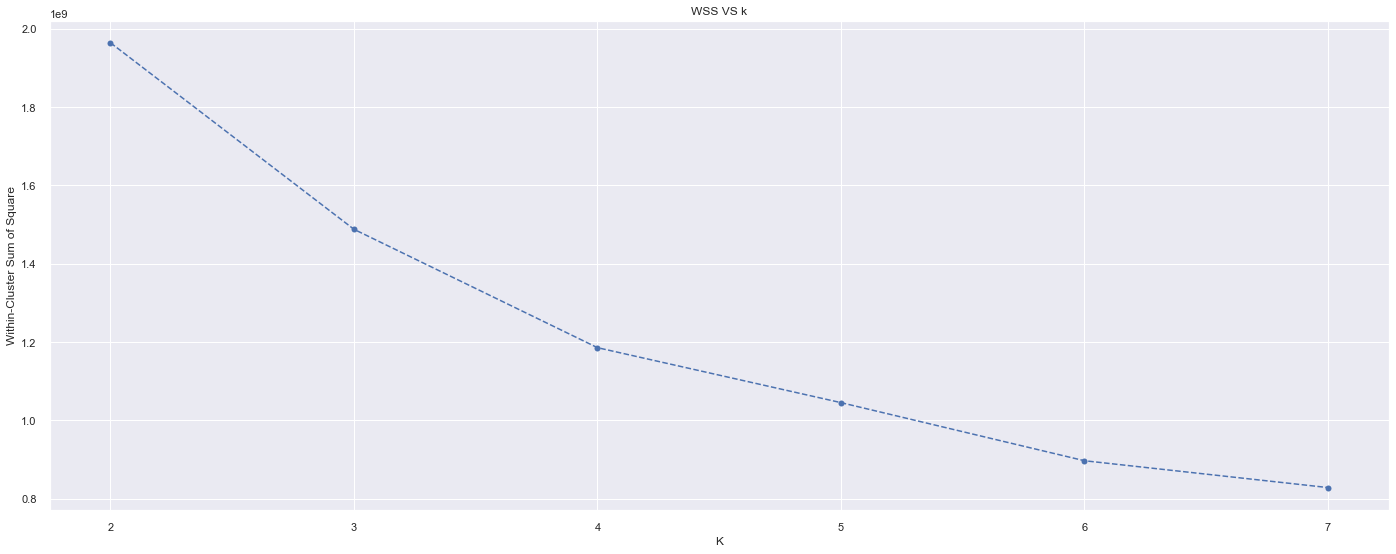

In [217]:
wss = []
for k in clusters:
    # model definition  
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
    # model training 
    kmeans.fit( X )
    # validation 
    wss.append(kmeans.inertia_)
    
# plot wss - ELBOW METHOD 
# tenho que escolher o lugar que o ponto mais se desloca e testar para saber o cluster para utilizar nesse exemplo foi 3 e 5
plt.plot (clusters, wss,linestyle='--', marker='o', color='b')
plt.xlabel ( 'K');
plt.ylabel ( 'Within-Cluster Sum of Square')
plt.title( 'WSS VS k');

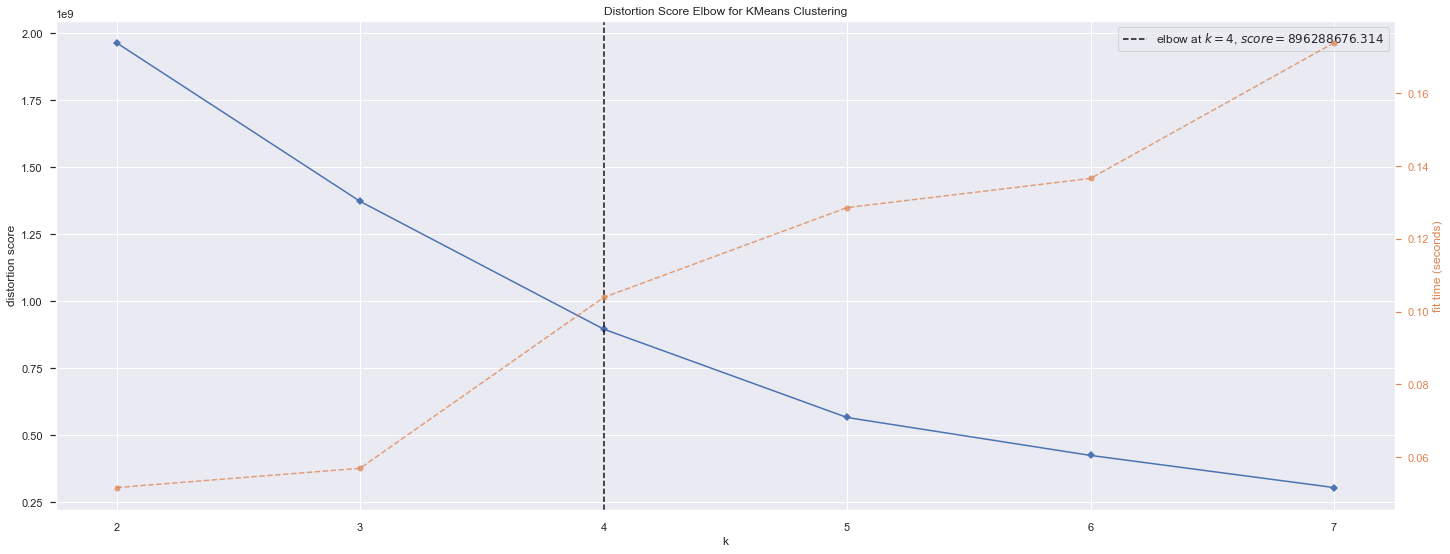

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [218]:
# from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timinings=False)
kmeans.fit( X )
kmeans.show()

## 7.2. Sillhouette Score

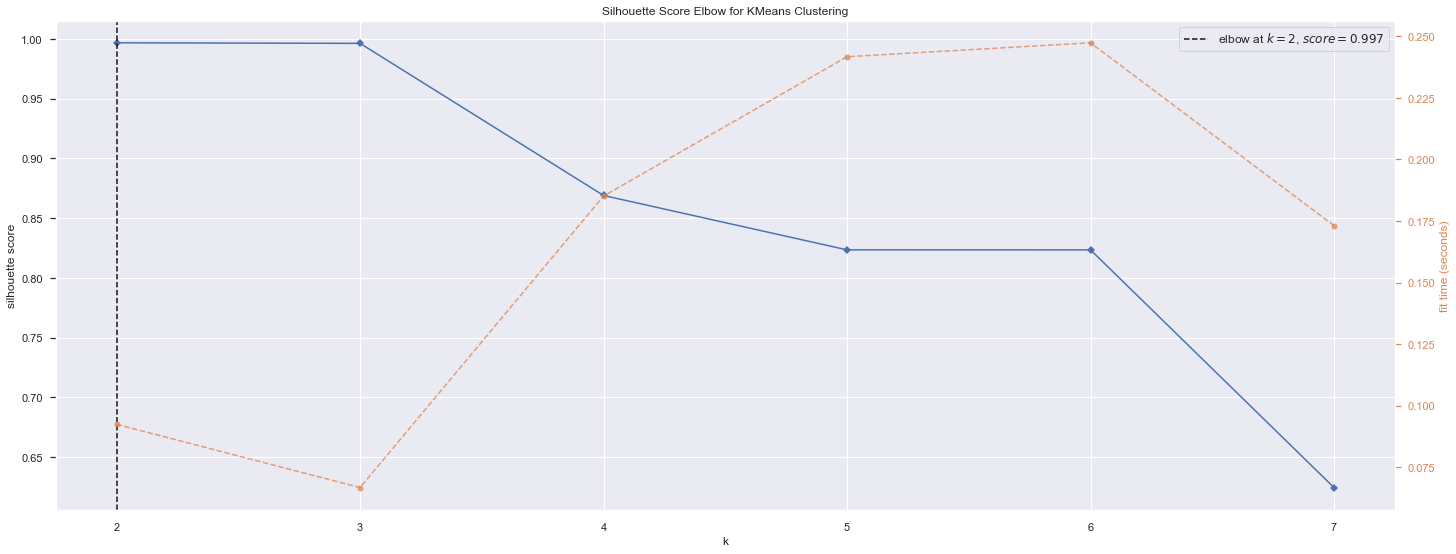

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [219]:
# from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timinings=False)
kmeans.fit( X )
kmeans.show()
# problema com modulo

## 7.3. Silhouette Analysis

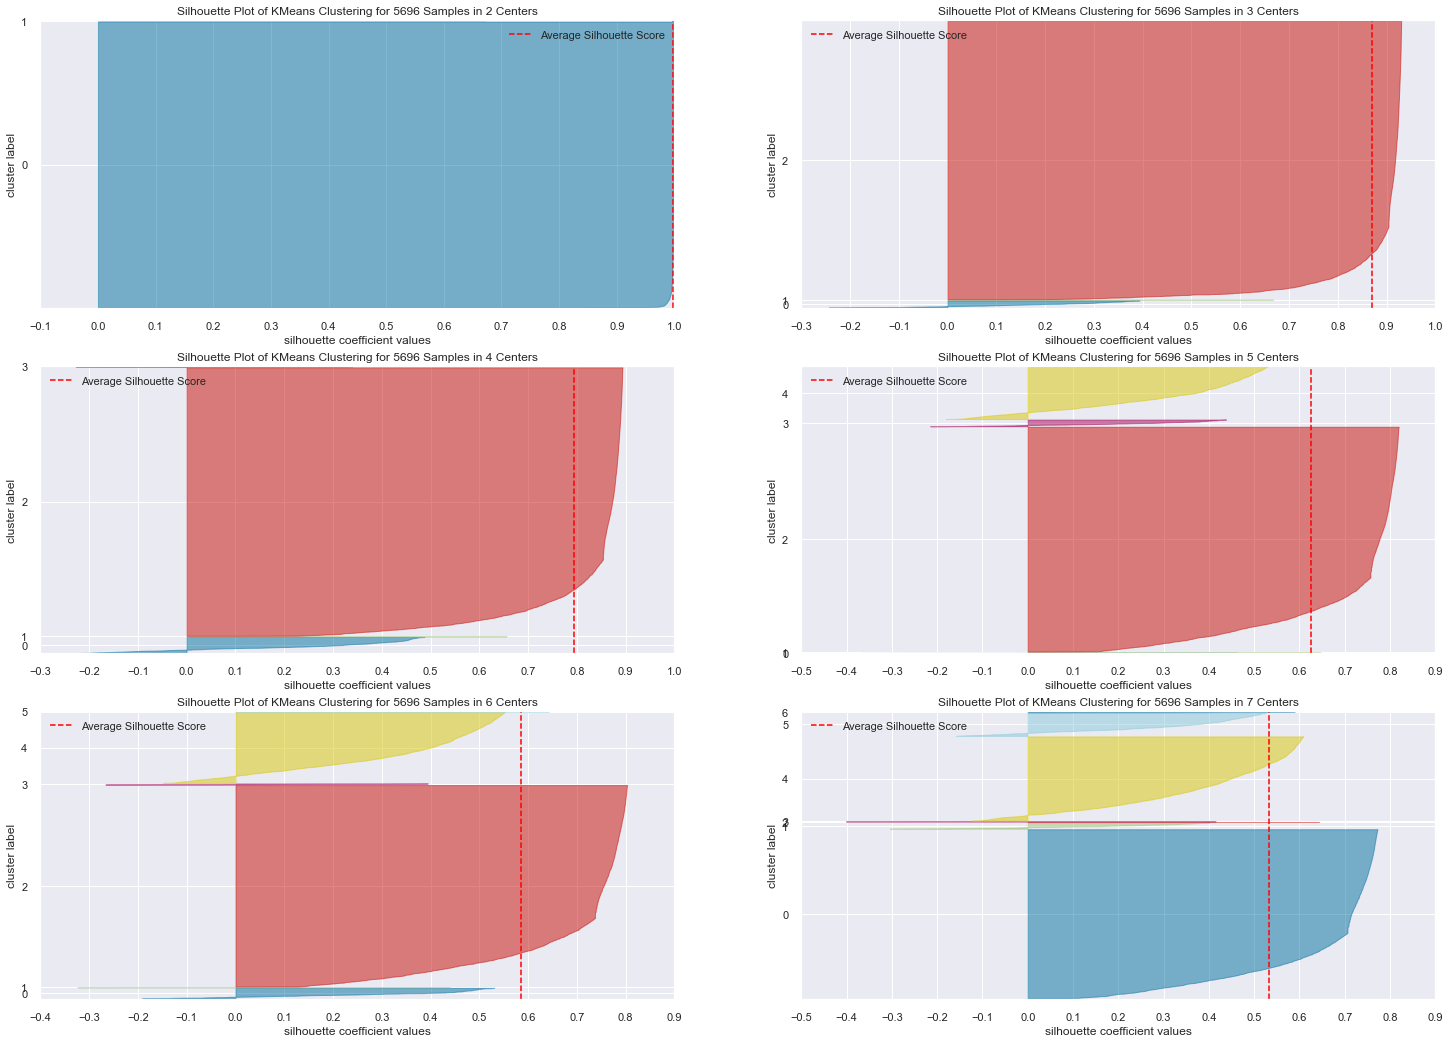

In [221]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [222]:
# model definition
k = 4 #valor de cluster do kmeans
kmeans= c.KMeans( init= 'random', n_clusters=k, n_init=10, max_iter=300, random_state=42) # init='random' modo aleatorio porem igual sempre q rodar

#model training 
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

## 8.2. Cluster Validation

In [223]:
## WSS ( Within-cluster sum of square)
print( 'WSS value {}'.format( kmeans.inertia_))

## SS ( Silhouette Score)
print( 'SS value: {}'.format(m.silhouette_score ( X, labels, metric='euclidean')))


WSS value 1185354134.6962328


AttributeError: 'DataFrame' object has no attribute 'silhouette_score'

# <font color='red'> 9.0. Cluster Analysis </font>

In [224]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.019312,0.997319,0.160976,6.0,0.000230,17.000000,40.0,50.970588,8.735294,2
1,13047,0.011579,0.150134,0.039024,11.0,0.000239,0.028302,35.0,154.444444,19.000000,2
2,12583,0.024020,0.005362,0.068293,24.0,0.000369,0.040323,50.0,335.200000,15.466667,2
3,13748,0.003396,0.254692,0.019512,8.0,0.000433,0.017921,0.0,87.800000,5.600000,2
4,15100,0.003137,0.892761,0.009756,2.0,0.003778,0.073171,22.0,26.666667,1.000000,2


## 9.1. Visualization Inspection

C:\Users\Yves Moura\.conda\envs\DataScienceEmProducao\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


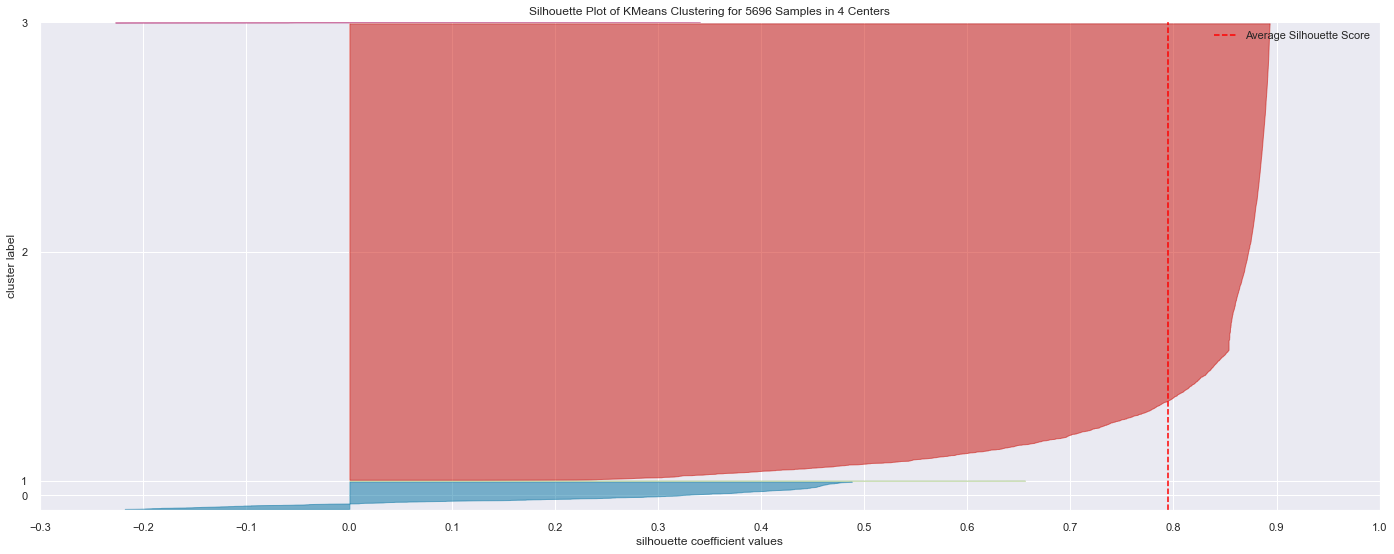

In [225]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

In [226]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

## 9.2. 2d plot

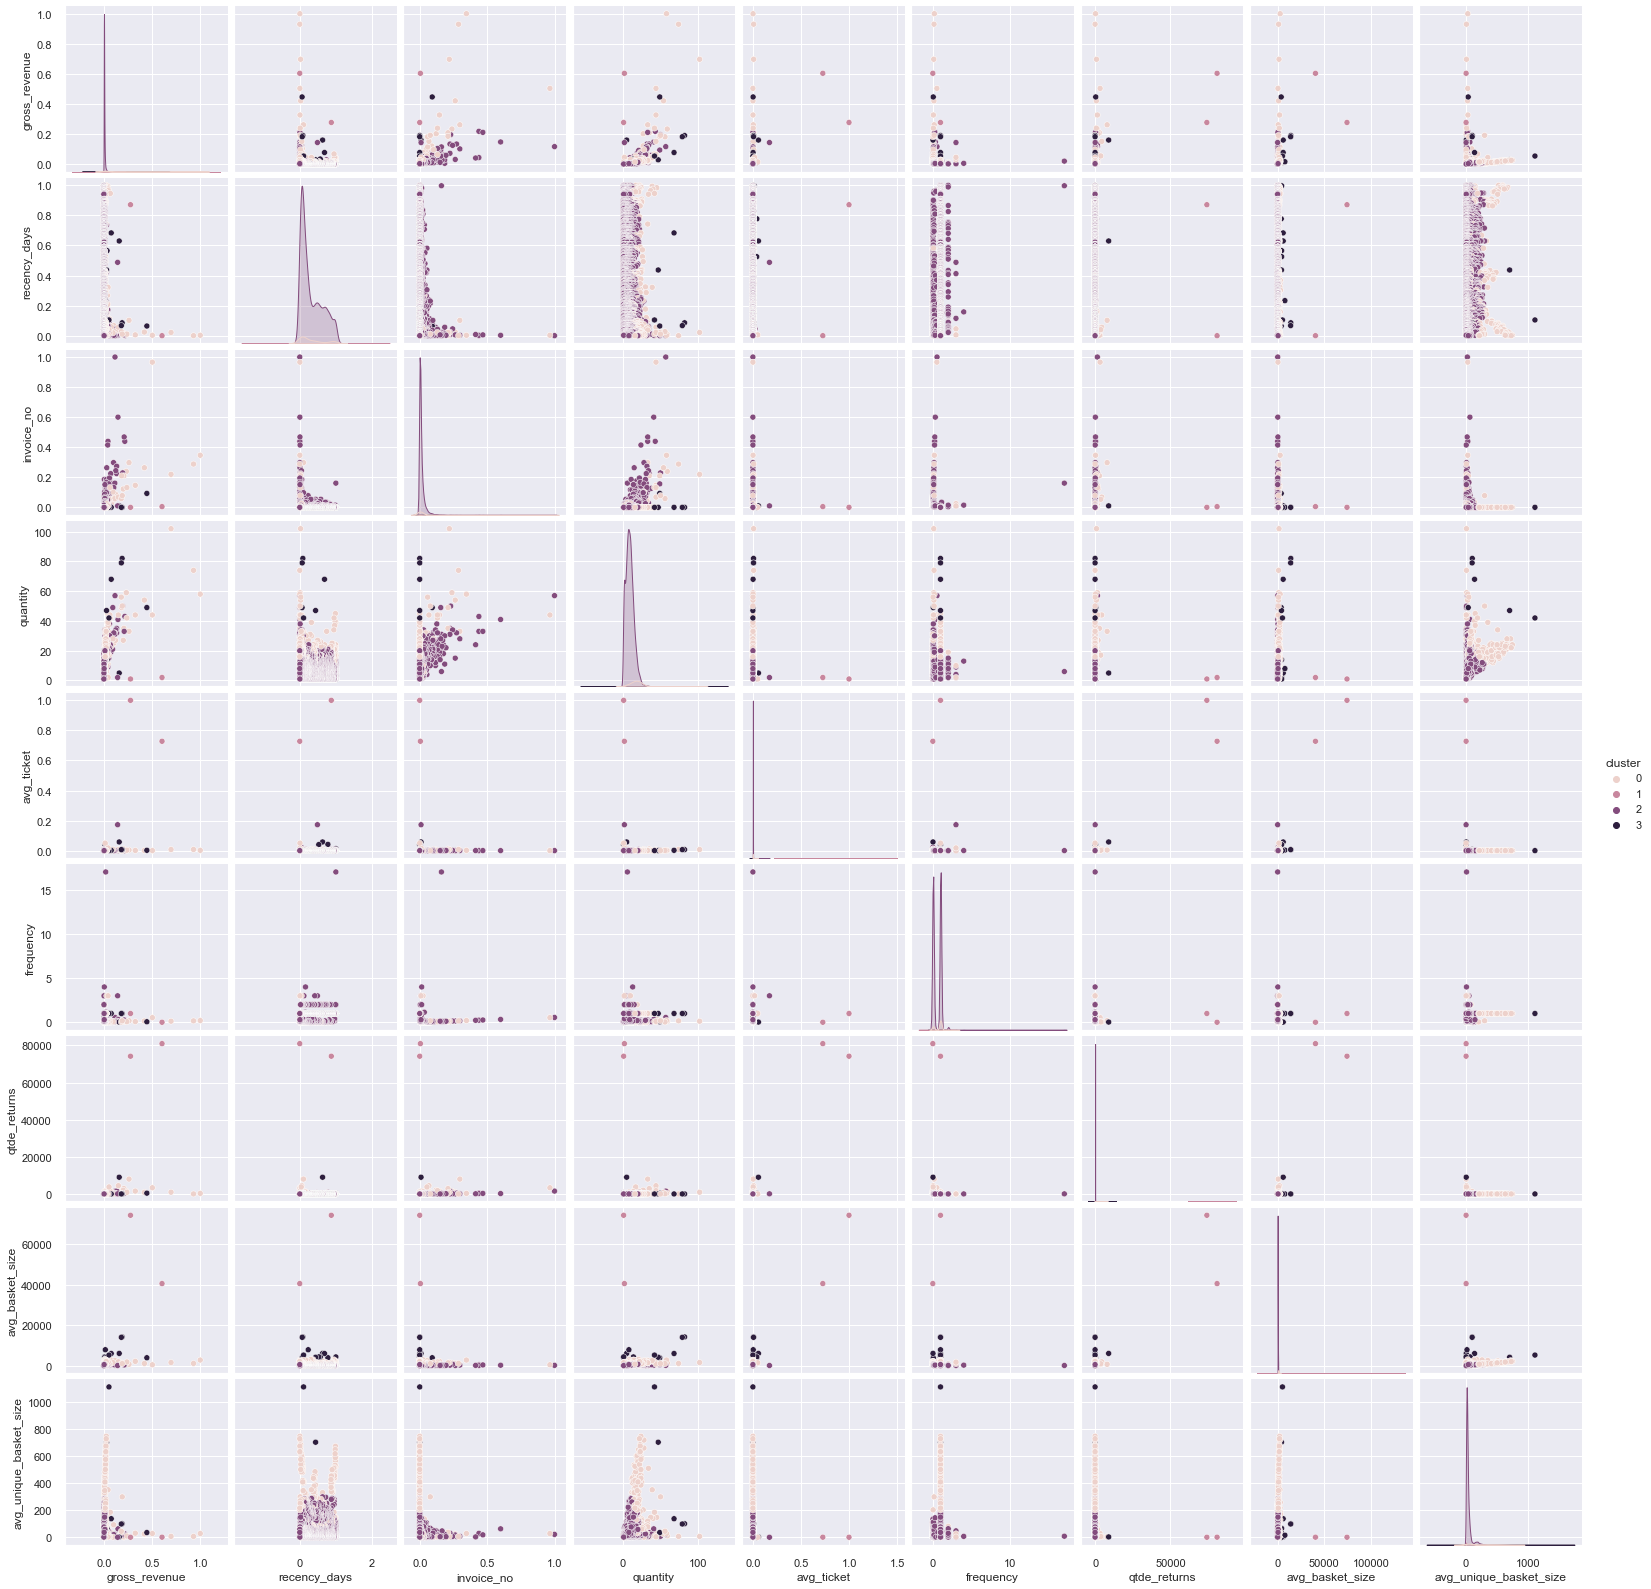

In [227]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

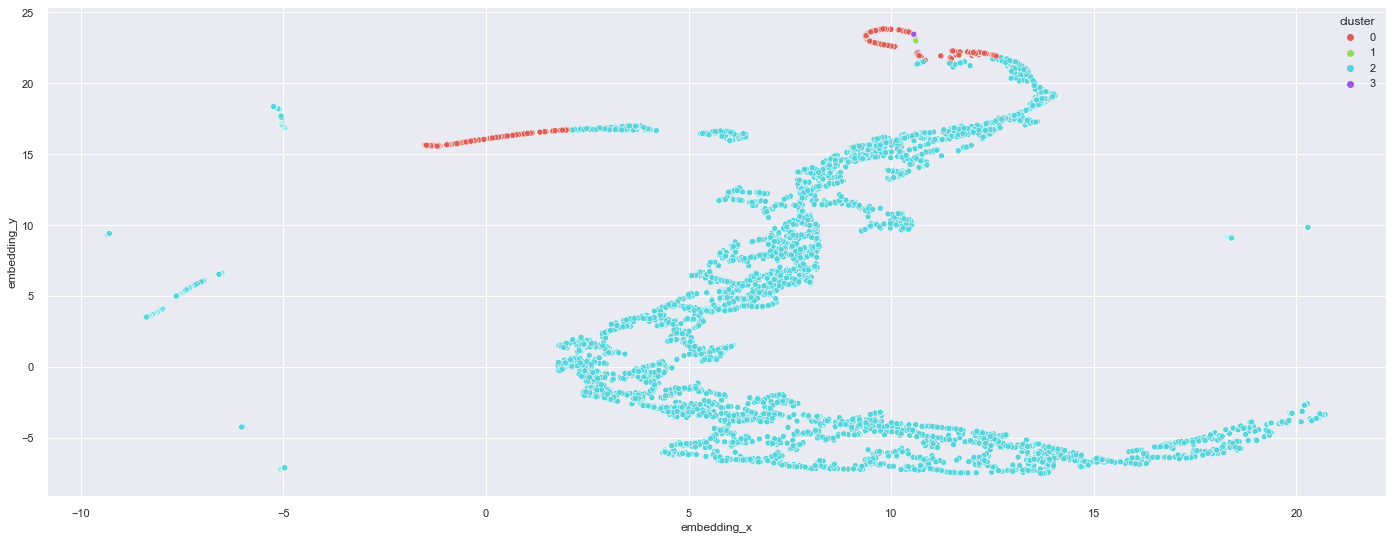

In [228]:
reducer = umap.UMAP( n_neighbors=15,random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profle

In [ ]:
# Number of customer 
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue 
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_gross_days = df9[['recency_days', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_gross_no = df9[['invoice_no', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')




In [80]:
df_cluster.shape

NameError: name 'df_cluster' is not defined

## Cluster 01: ( Candidato à Insider)
    - Número de customers: 6 (0.14% do customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: 182.182,00 dólares
    
## Cluster 02:
    - Número de customers: 31 (0.71% do customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: 40.543,00 dólares
    
## Cluster 03:
    - Número de customers: 4.335 (99% do customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: 1.372,57 dólares
    

# <font color='red'> 10.0. Deploy to Production </font>